# ICPE Data Challenge 2024

This notebook contains analyses of the Globus dataset with the aim to analyze what proportion of tasks submitted on the platform are not latency-sensitive: that is, they are delayable.

Our findings here can further support the idea of delaying tasks in serverless architectures to improve latency and throughput of latency-sensitive tasks, and also result in fewer resource usage and cost for the users of the platform.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [3]:
sns.set_style('whitegrid')

In [4]:
tasks = pd.read_csv("../datasets/GlobusComputeDataset-v1-tasks.csv")

In [5]:
tasks = tasks.dropna(subset=['received', 'result_received'])

In [6]:
functions = pd.read_csv("../datasets/GlobusComputeDataset-v1-functions.csv")

## Analyzing task latencies

In [6]:
task_latencies = pd.DataFrame({"Task latency (seconds)": (tasks["result_received"] - tasks["received"]) / 1000000000})

In [7]:
total_tasks = task_latencies.shape[0]

In [8]:
latencies_v = task_latencies['Task latency (seconds)']

In [ ]:
plt.figure(figsize=(10, 10))

ax = sns.histplot(
    data=task_latencies,
    bins=math.ceil(math.log2(total_tasks) + 1),
    log_scale=True
)

ax.get_legend().remove()

for rect in ax.patches:
    width, height = rect.get_width(), rect.get_height()
    x = rect.get_x()

    if height < 50000: continue
    
    bin_mask = (latencies_v >= x) & (latencies_v < x + width)
    bin_mean = latencies_v[bin_mask].mean().mean()
    
    plt.text(x + width/2., height, f"{bin_mean:.03}s", ha='center', va='bottom', rotation=45)

plt.ylabel('')
plt.xlabel('Task latencies from received to response received (seconds)')

In [ ]:
plt.figure(figsize=(10, 10))

ax = sns.histplot(
    data=task_latencies,
    bins=math.ceil(math.log2(total_tasks) + 1),
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False
)

ax.get_legend().remove()

mean_0_1 = latencies_v[(latencies_v <= 1) & (latencies_v >= 0)].mean()
mean_0_2 = latencies_v[(latencies_v > 1) & (latencies_v <= 5)].mean()
mean_0_3 = latencies_v[(latencies_v > 5) & (latencies_v <= 100)].mean()

plt.axvline(x=1, color='r', linestyle='--', label=f'Mean at [0, 1]')
plt.text(1.1, 0.3, f'{mean_0_1:.2f}s', ha="left", va="bottom")

plt.axvline(x=5, color='purple', linestyle='--', label=f'Mean at (1, 5]')
plt.text(6, 0.5, f'{mean_0_2:.2f}s', ha="left", va="bottom")

plt.axvline(x=100, color='g', linestyle='--', label=f'Mean at (5, 100]')
plt.text(120, 0.3, f'{mean_0_3:.2f}s', ha="left", va="bottom")

plt.legend()

plt.ylabel('CDF')
plt.xlabel('Task latencies from received to response received (seconds)')

In [11]:
less_than_1_second = latencies_v[latencies_v < 1]
more_than_1_second = latencies_v[latencies_v >= 1]
more_than_2_seconds = latencies_v[latencies_v >= 2]
more_than_5_seconds = latencies_v[latencies_v >= 5]

In [12]:
pct_less_1 = less_than_1_second.shape[0] / total_tasks
pct_more_1 = more_than_1_second.shape[0] / total_tasks
pct_more_2 = more_than_2_seconds.shape[0] / total_tasks
pct_more_5 = more_than_5_seconds.shape[0] / total_tasks

In [ ]:
plt.figure(figsize=(10, 10))

categories = pd.DataFrame({
    'Percentage': [pct_less_1, pct_more_1, pct_more_2, pct_more_5], 
    'Latency category': ['< 1 second', '>= 1 second', '>= 2 seconds', '>= 5 seconds']
})

bar_colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700']

sns.barplot(categories, x='Percentage', y='Latency category', hue='Latency category', alpha=.7, orient='y')

for index, row in categories.iterrows():
    pct = row['Percentage']
    plt.text(pct, index, f'{pct:.2}%', color='black', va="center")

plt.title('Percentage of Tasks in Different Latency Categories')
plt.xlabel('Latency Category')
plt.ylabel('Percentage')

## Same analysis on 3 thresholds

We are interested in the following numbers:

- 30s (HTTP timeout)
- 45 & 80 seconds (Cold starts paper)

We want to know what proportion of tasks submitted on the Globus platform present latencies higher than these times.

Text(0, 0.5, 'Percentage')

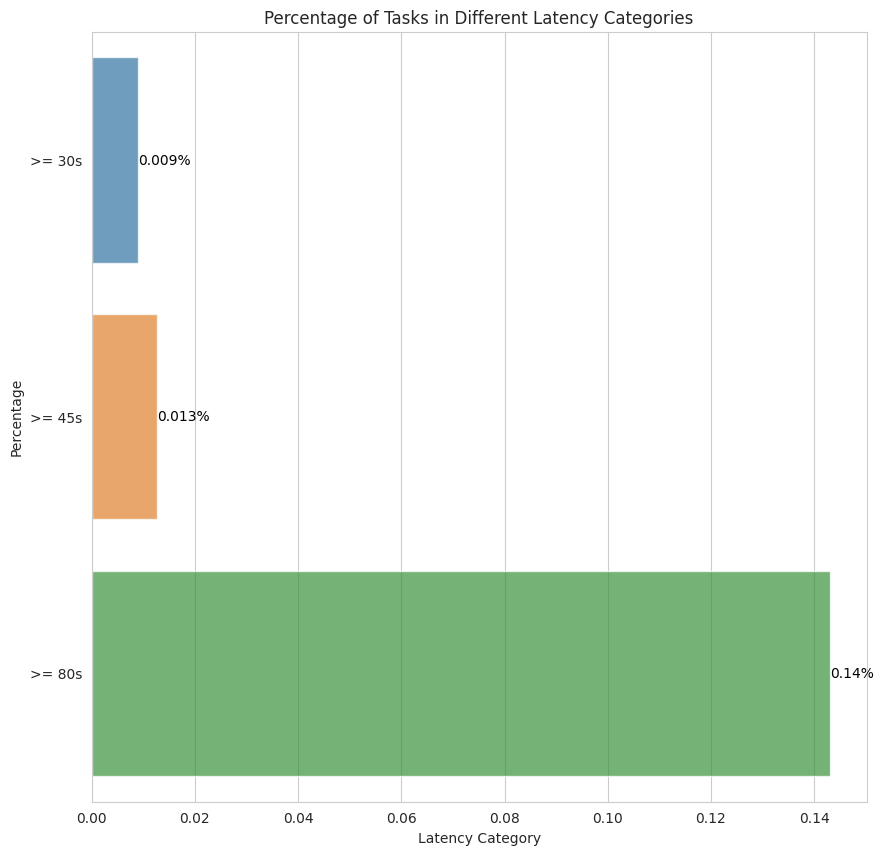

In [17]:
a = latencies_v[(latencies_v >= 30) & (latencies_v < 45)].shape[0] / total_tasks
b = latencies_v[(latencies_v >= 45) & (latencies_v < 80)].shape[0] / total_tasks
c = latencies_v[latencies_v >= 80].shape[0] / total_tasks

plt.figure(figsize=(10, 10))

categories = pd.DataFrame({
    'Percentage': [a, b, c], 
    'Latency category': ['>= 30s', '>= 45s', '>= 80s']
})

bar_colors = ['#FF6347', '#4682B4', '#32CD32']

sns.barplot(categories, x='Percentage', y='Latency category', hue='Latency category', alpha=.7, orient='y')

for index, row in categories.iterrows():
    pct = row['Percentage']
    plt.text(pct, index, f'{pct:.2}%', color='black', va="center")

plt.title('Percentage of Tasks in Different Latency Categories')
plt.xlabel('Latency Category')
plt.ylabel('Percentage')

## Analyzing task function categories

The following cells use private datasets so you will probably not be able to run them :)

In [7]:
fmappings = pd.read_csv('../datasets/functions_collect.csv', sep=";", header=0, names=['ID', 'category'])

In [26]:
fmappings.head()

,ID,category
0,0065bac2-ae2b-6e2d-0a1a-82c35e209c61,ML
1,90736664-cd01-d861-0b86-126f38745bea,ML
2,1282d769-55ef-f054-4659-fc8434516c99,ML
3,7d24319b-59ea-ab2e-5f71-0f13aa2112c4,ML
4,6eba3376-d55c-ff47-dd08-c9863393974d,ML


In [28]:
fmappings['category'].unique()

array(['ML', 'Scientific Computing', 'Trivial', 'Job Scheduling',
       'Unclustered'], dtype=object)

### How many of the functions in the Globus platform fall into categories known to be not latency sensitive?

From the cold-starts paper:

> In addition, many batch workloads, such as machine learning (ML), require hardware acceleration [27, 32, 58]. Accelerators are an expensive resource and hard to provision and configure [17]. We believe that – in the way how serverless achieved CPU and memory transparency for functions - serverless for batch workloads can achieve accelerator transparency. The corresponding improvements in cost and ease-of-use would make serverless an attractive execution model for accelerated batch workloads.

Furthermore, ML inference/training tasks are deemed not latency sensitive in that paper. Data analysis (Scientific computing) is also deemed as not latency sensitve. Thus, it would be interesting if most of them were ML or Scientific Computing tasks.

In [31]:
tasks.head()

,task_uuid,function_uuid,endpoint_uuid,anonymized_user_uuid,argument_size,received,waiting_for_nodes,waiting_for_launch,execution_start,execution_end,result_received
0,0ebb4c18-5d2c-4804-4329-17725d94788d,fef43cc0-a26a-b13f-e956-3455b3d24a41,651538d8-3fc4-98d6-c6a4-f89ecadd2544,def8a1a7-9bc1-e274-1213-3d6cb366d6e9,659.0,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18
2,fd4004eb-eb9c-d3d6-b718-93cb1c91c6d9,f9fb1939-d0e5-bb44-719b-1fca97a34a8f,9b1d9849-dd78-51bb-cb47-c48ebc5ef9c9,89f2c306-4c36-ffed-2553-e86692f055c3,46.0,1.686630e+18,1.686630e+18,1.686630e+18,1.686630e+18,1.686630e+18,1.686630e+18
3,2a1e96f6-7999-b066-fc7b-e6adf8567031,eb1a35bc-eb3a-a4dd-c905-82823f30677d,9b1d9849-dd78-51bb-cb47-c48ebc5ef9c9,89f2c306-4c36-ffed-2553-e86692f055c3,46.0,1.686687e+18,1.686687e+18,1.686687e+18,1.686687e+18,1.686687e+18,1.686687e+18
4,7ee1af85-bec6-50af-50d9-0c9dfbdabcc5,b4c9f870-b439-866c-79ac-abdf5ac4b9a2,57699a1f-f727-b5ef-28db-afaffeb0cb4d,e9abae78-6295-f7c7-17de-fc5f58818a2b,11433.0,1.684338e+18,1.684338e+18,1.684338e+18,1.684338e+18,1.684338e+18,1.684338e+18
5,ed0aa6c5-514d-45e3-703c-766279b08013,62681d2a-6c86-71dc-0e6c-9e8cd2bab13d,c84b6f08-caf5-11b0-de91-b0f7a2eec775,a7982e64-0077-bc42-12dc-d36ff6e9f672,46.0,1.683751e+18,1.683751e+18,1.683751e+18,1.683751e+18,1.683751e+18,1.683751e+18


In [8]:
cat = tasks.merge(fmappings, left_on='function_uuid', right_on='ID', how='inner')

In [10]:
cat.head()

,task_uuid,function_uuid,endpoint_uuid,anonymized_user_uuid,argument_size,received,waiting_for_nodes,waiting_for_launch,execution_start,execution_end,result_received,ID,category
0,0ebb4c18-5d2c-4804-4329-17725d94788d,fef43cc0-a26a-b13f-e956-3455b3d24a41,651538d8-3fc4-98d6-c6a4-f89ecadd2544,def8a1a7-9bc1-e274-1213-3d6cb366d6e9,659.0,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,fef43cc0-a26a-b13f-e956-3455b3d24a41,ML
1,0ebb4c18-5d2c-4804-4329-17725d94788d,fef43cc0-a26a-b13f-e956-3455b3d24a41,651538d8-3fc4-98d6-c6a4-f89ecadd2544,def8a1a7-9bc1-e274-1213-3d6cb366d6e9,659.0,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,fef43cc0-a26a-b13f-e956-3455b3d24a41,ML
2,0ebb4c18-5d2c-4804-4329-17725d94788d,fef43cc0-a26a-b13f-e956-3455b3d24a41,651538d8-3fc4-98d6-c6a4-f89ecadd2544,def8a1a7-9bc1-e274-1213-3d6cb366d6e9,659.0,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,fef43cc0-a26a-b13f-e956-3455b3d24a41,ML
3,0ebb4c18-5d2c-4804-4329-17725d94788d,fef43cc0-a26a-b13f-e956-3455b3d24a41,651538d8-3fc4-98d6-c6a4-f89ecadd2544,def8a1a7-9bc1-e274-1213-3d6cb366d6e9,659.0,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,fef43cc0-a26a-b13f-e956-3455b3d24a41,ML
4,0ebb4c18-5d2c-4804-4329-17725d94788d,fef43cc0-a26a-b13f-e956-3455b3d24a41,651538d8-3fc4-98d6-c6a4-f89ecadd2544,def8a1a7-9bc1-e274-1213-3d6cb366d6e9,659.0,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,fef43cc0-a26a-b13f-e956-3455b3d24a41,Scientific Computing


In [11]:
cat = cat[['ID', 'category', 'received', 'result_received']]

In [12]:
cat.head()

,ID,category,received,result_received
0,fef43cc0-a26a-b13f-e956-3455b3d24a41,ML,1.685553e+18,1.685553e+18
1,fef43cc0-a26a-b13f-e956-3455b3d24a41,ML,1.685553e+18,1.685553e+18
2,fef43cc0-a26a-b13f-e956-3455b3d24a41,ML,1.685553e+18,1.685553e+18
3,fef43cc0-a26a-b13f-e956-3455b3d24a41,ML,1.685553e+18,1.685553e+18
4,fef43cc0-a26a-b13f-e956-3455b3d24a41,Scientific Computing,1.685553e+18,1.685553e+18


In [16]:
category_counts = cat.value_counts(subset=['category']).reset_index()

In [17]:
category_counts

,category,count
0,Trivial,48346499
1,Scientific Computing,4793634
2,Job Scheduling,2512814
3,ML,871443
4,Unclustered,7871


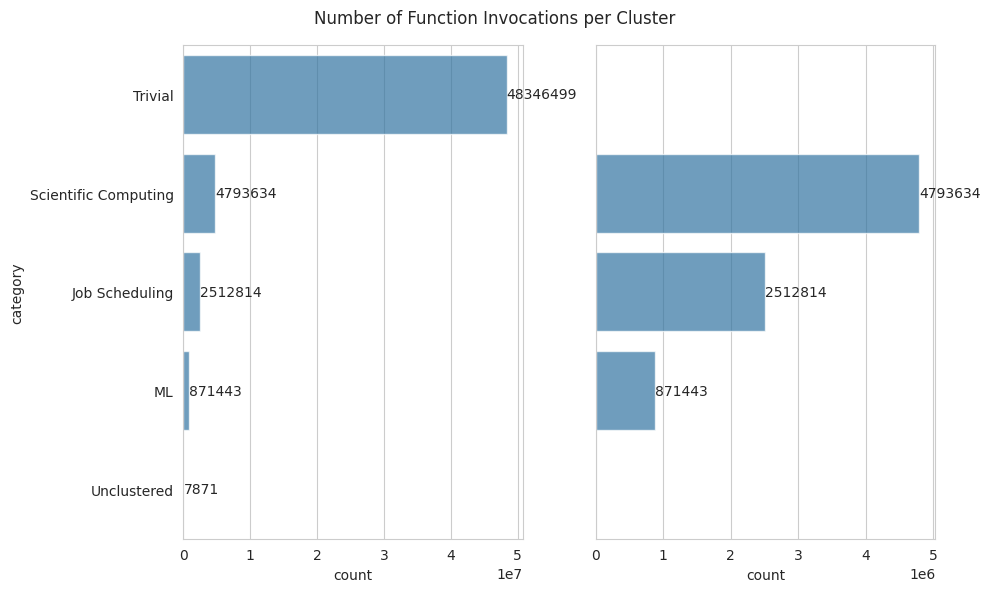

In [60]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)

sns.barplot(category_counts, x='count', y='category', alpha=.7, orient='y', ax=ax1)
for c in ax1.containers: ax1.bar_label(c, fmt='{:.0f}')

sns.barplot(category_counts[~category_counts['category'].str.match(r"Trivial|Unclustered")], x='count', y='category', alpha=.7, orient='y', ax=ax2)
for c in ax2.containers: ax2.bar_label(c, fmt='{:.0f}')

fig.suptitle('Number of Function Invocations per Cluster')
fig.tight_layout()

### What does the relation between a function's category and it's corresponding task latency look like?

Knowing this will give use confidence that functions from a given category are in fact latency insensitive, but it doesn't mean that if a function has a low latency it is not latency insensitive.

For this, we are going to add a new column to the tasks dataset indicating the type of latency if presents:

- LOW if latency is less than 30s
- 30 if latency is more than 30s but less than 45s
- 45 if latency is more than 45s but less than 80s
- 80 if latency is more than 80s

With this new column, we can compute the correlation between the latency type and function cluster. Since we are working with categorical data, we can use Cramer's V.

In [62]:
tasks.head()

,task_uuid,function_uuid,endpoint_uuid,anonymized_user_uuid,argument_size,received,waiting_for_nodes,waiting_for_launch,execution_start,execution_end,result_received
0,0ebb4c18-5d2c-4804-4329-17725d94788d,fef43cc0-a26a-b13f-e956-3455b3d24a41,651538d8-3fc4-98d6-c6a4-f89ecadd2544,def8a1a7-9bc1-e274-1213-3d6cb366d6e9,659.0,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18,1.685553e+18
2,fd4004eb-eb9c-d3d6-b718-93cb1c91c6d9,f9fb1939-d0e5-bb44-719b-1fca97a34a8f,9b1d9849-dd78-51bb-cb47-c48ebc5ef9c9,89f2c306-4c36-ffed-2553-e86692f055c3,46.0,1.686630e+18,1.686630e+18,1.686630e+18,1.686630e+18,1.686630e+18,1.686630e+18
3,2a1e96f6-7999-b066-fc7b-e6adf8567031,eb1a35bc-eb3a-a4dd-c905-82823f30677d,9b1d9849-dd78-51bb-cb47-c48ebc5ef9c9,89f2c306-4c36-ffed-2553-e86692f055c3,46.0,1.686687e+18,1.686687e+18,1.686687e+18,1.686687e+18,1.686687e+18,1.686687e+18
4,7ee1af85-bec6-50af-50d9-0c9dfbdabcc5,b4c9f870-b439-866c-79ac-abdf5ac4b9a2,57699a1f-f727-b5ef-28db-afaffeb0cb4d,e9abae78-6295-f7c7-17de-fc5f58818a2b,11433.0,1.684338e+18,1.684338e+18,1.684338e+18,1.684338e+18,1.684338e+18,1.684338e+18
5,ed0aa6c5-514d-45e3-703c-766279b08013,62681d2a-6c86-71dc-0e6c-9e8cd2bab13d,c84b6f08-caf5-11b0-de91-b0f7a2eec775,a7982e64-0077-bc42-12dc-d36ff6e9f672,46.0,1.683751e+18,1.683751e+18,1.683751e+18,1.683751e+18,1.683751e+18,1.683751e+18


In [8]:
tasks['end-to-end'] = (tasks["result_received"] - tasks["received"]) / 1000000000

In [9]:
tasks['latyp'] = np.where(
    tasks['end-to-end'] < 30, 'LOW', np.where(
    (tasks['end-to-end'] >= 30) & (tasks['end-to-end'] < 45), '30', np.where(
    (tasks['end-to-end'] >= 45) & (tasks['end-to-end'] < 80), '45',
    '80'
)))

In [ ]:
# TODO: Kernel keeps dying on this shit
df = tasks.merge(fmappings, left_on='function_uuid', right_on='ID', how='inner')

### What are the clusters of the functions in the latency categories analyzed earlier (30s, 45s, 80s)?

Answering this question will let us further relate a function's cluster to having high or low latency.